In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.measure
import scipy.ndimage
from scipy.interpolate import interp2d

from src.datasets import BiosensorDataset, create_datasets
from src.test_models.test_parts import *
from src.train import train_model
from src.evaluate import evaluate
from src.utils import *

c:\Users\wittd\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
data_path = 'C:/onlab_git/Onlab/data_with_centers/'
train_percent = 0.614
test_percent = 0.30


files = os.listdir(data_path)
train_size = int(train_percent * len(files))
val_size = len(files) - train_size
if test_percent>0:
    test_size = int(test_percent * len(files))
    val_size = val_size - test_size

print('Train size:', train_size)
print('Validation size:', val_size)
print('Test size:', test_size)

Train size: 100
Validation size: 15
Test size: 48


In [14]:
# wrong_masks = ['33.npz', '38.npz', '56.npz', '58.npz', '59.npz', '68.npz', '78.npz', '99.npz', '100.npz', '103.npz', '106.npz', '108.npz', '109.npz', '110.npz', '112.npz', '113.npz', '119.npz', '121.npz', '123.npz', '130.npz', '131.npz', '143.npz']
cell_count_issue = ['56.npz','68.npz', '130.npz', '131.npz']
basic_padding_fix = ['33.npz', '38.npz',  '58.npz', '59.npz',  '78.npz', '119.npz', '121.npz', '123.npz']
top_padding_fix = ['99.npz', '100.npz', '110.npz', '113.npz', '143.npz']
hard_padding_fix = [ '103.npz', '106.npz', '108.npz', '109.npz', '112.npz']

In [68]:
def plot_alignment(bio, mask, padded_mask, name, file):
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(bio, cmap='gray')
    plt.title(name)

    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(file)

    plt.subplot(1, 4, 3)
    plt.imshow(padded_mask, cmap='gray')
    plt.title('Padded mask')

    plt.subplot(1, 4, 4)
    plt.imshow(bio, cmap='gray')
    plt.imshow(scale_mask(padded_mask, 80), cmap='Reds', alpha=0.25)
    plt.show()
    
def basic_mask_padding(mask):
    X = mask.shape[0]
    Y = mask.shape[1]
    # Calculate padding
    if X > Y:
        padding = (0, X - Y, 0, 0)
    else:
        padding = (0, 0, 0, Y - X)
    return torch.nn.functional.pad(mask, padding, mode='constant', value=0)

def top_padding(mask):
    X = mask.shape[0]
    Y = mask.shape[1]
    # Calculate padding
    if Y > X:
        padding = (0, 0, Y - X, 0)
    else:
        padding = (0, 0, 0, 0)
    return torch.nn.functional.pad(mask, padding, mode='constant', value=0)

def scale_mask(mask, mask_size):
    interpolated_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(mask_size, mask_size), mode='nearest').squeeze(0).squeeze(0).byte()

    return interpolated_mask.cpu().numpy()

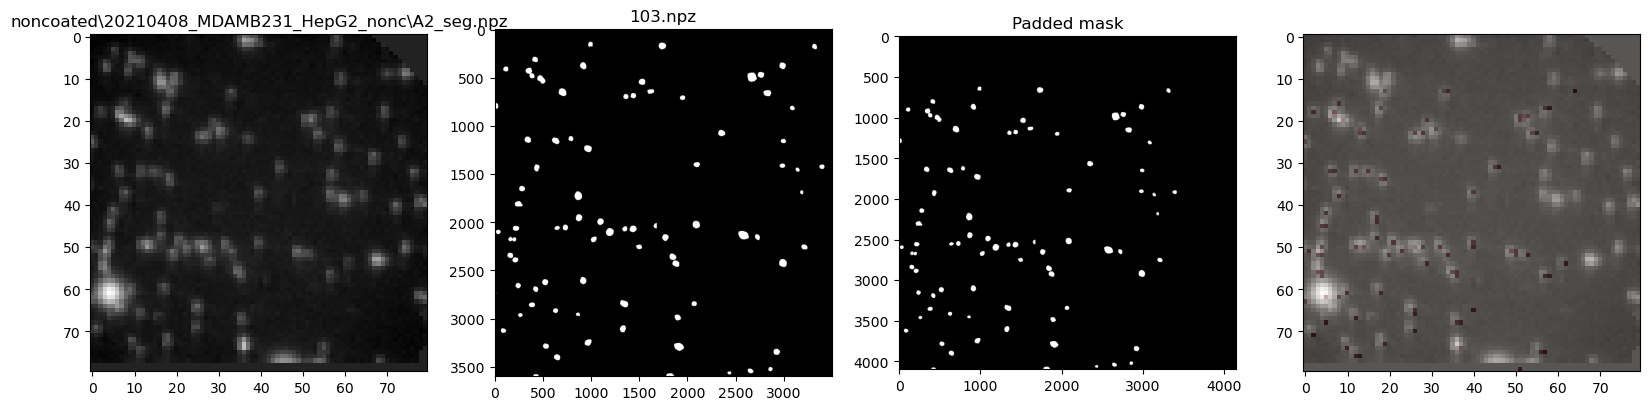

In [34]:
data = np.load(data_path + hard_padding_fix[0])

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(bool))

X = mask.shape[0]
Y = mask.shape[1]

padding = (0, 650, 500, 0)

padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

plot_alignment(bio[-1], mask, padded_mask, name, hard_padding_fix[0])

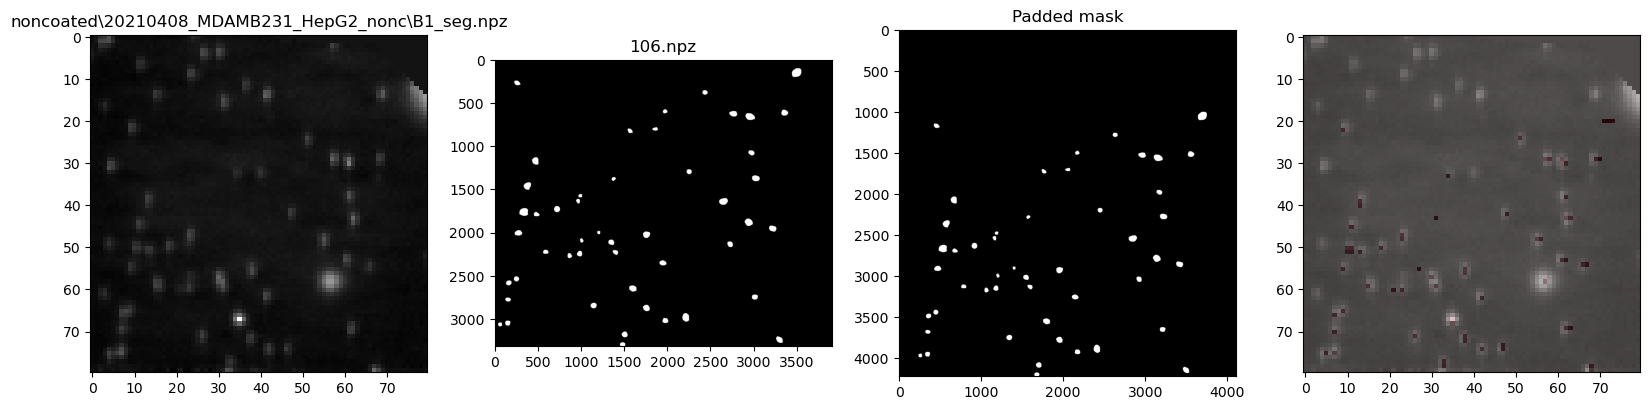

In [42]:
data = np.load(data_path + hard_padding_fix[1])

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(bool))

X = mask.shape[0]
Y = mask.shape[1]

padding = (200, 0, 900, 0)

padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

plot_alignment(bio[-1], mask, padded_mask, name, hard_padding_fix[1])
    

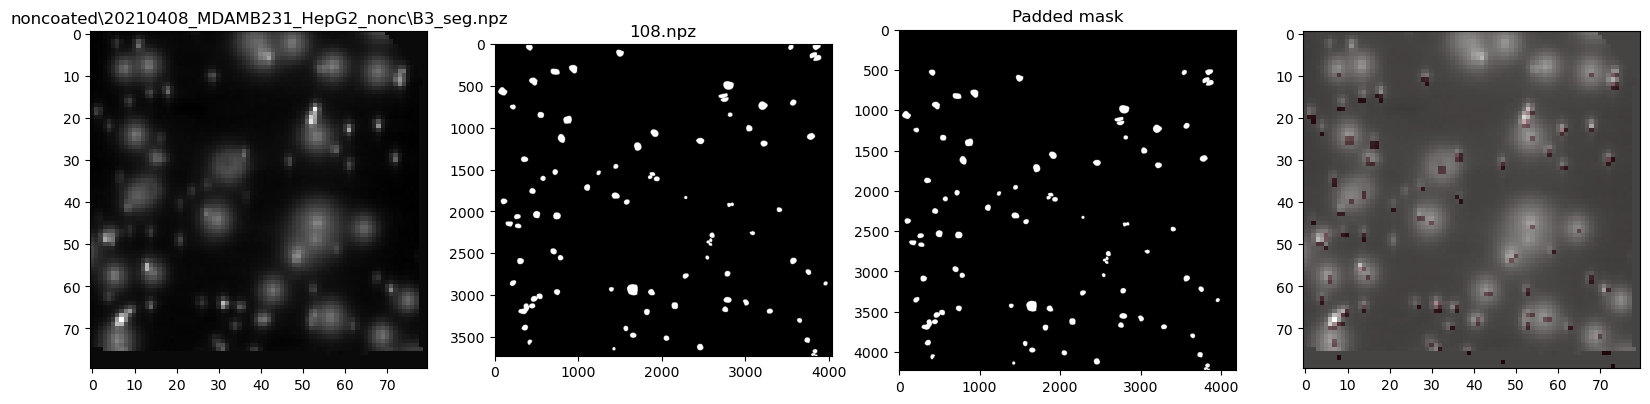

In [49]:
data = np.load(data_path + hard_padding_fix[2])

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(bool))

X = mask.shape[0]
Y = mask.shape[1]

padding = (0, 150, 500, 0)

padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

plot_alignment(bio[-1], mask, padded_mask, name, hard_padding_fix[2])

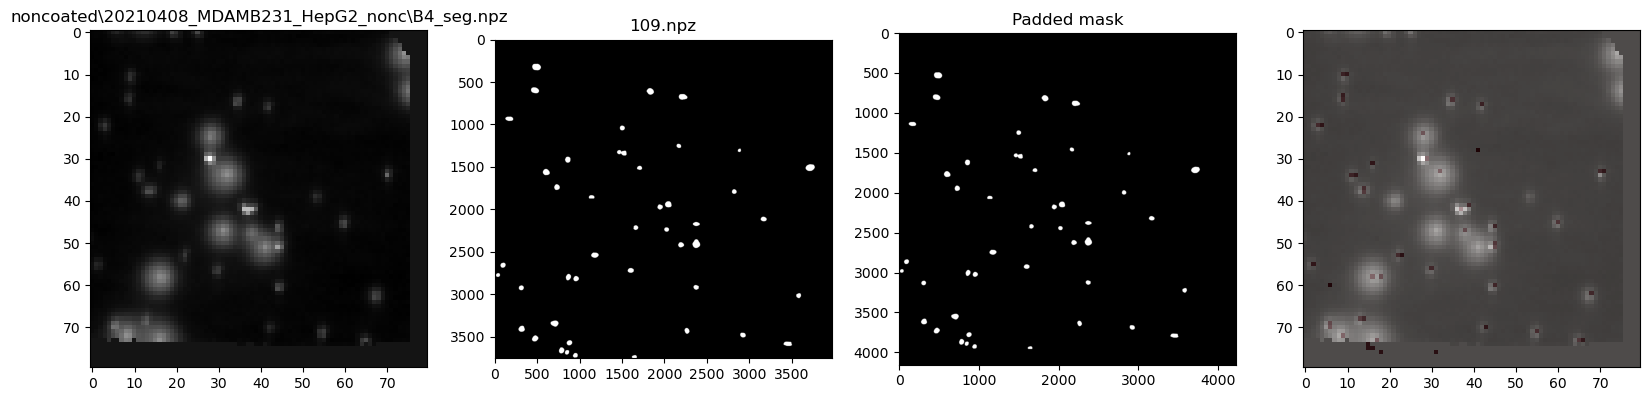

In [55]:
data = np.load(data_path + hard_padding_fix[3])

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(bool))

X = mask.shape[0]
Y = mask.shape[1]

padding = (0, 250, 200, 200)

padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

plot_alignment(bio[-1], mask, padded_mask, name, hard_padding_fix[3])

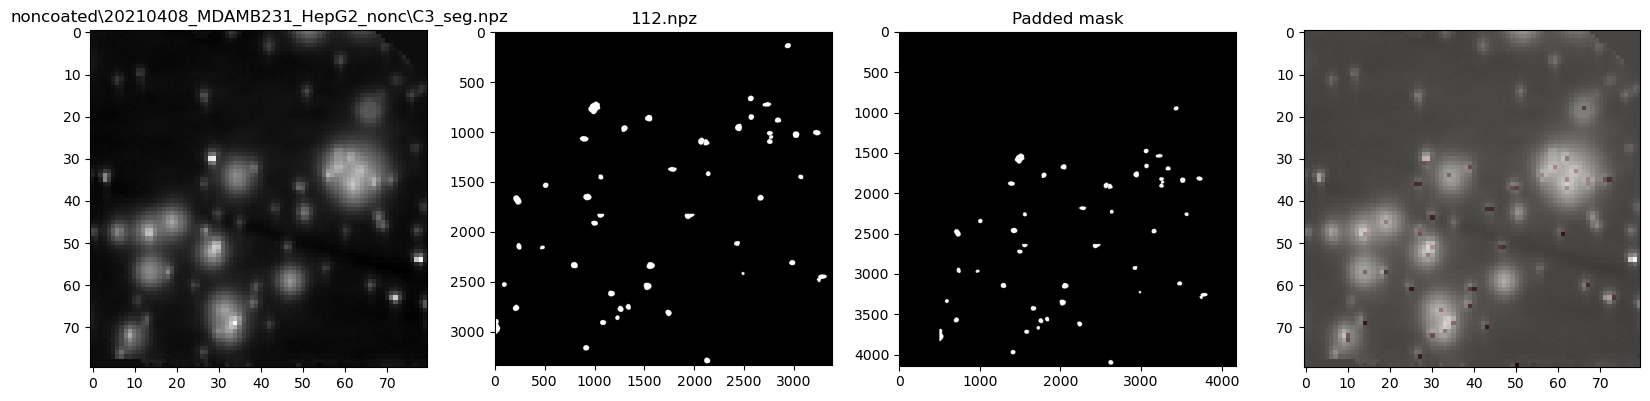

In [67]:
data = np.load(data_path + hard_padding_fix[4])

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(bool))

X = mask.shape[0]
Y = mask.shape[1]

padding = (500, 300, 800, 0)

padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

plot_alignment(bio[-1], mask, padded_mask, name, hard_padding_fix[4])

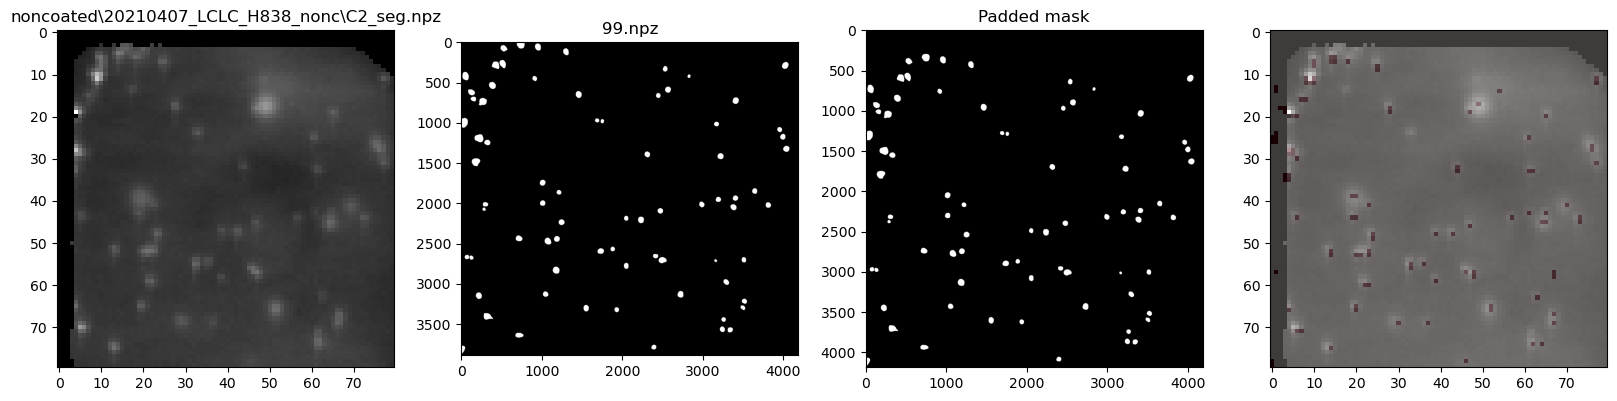

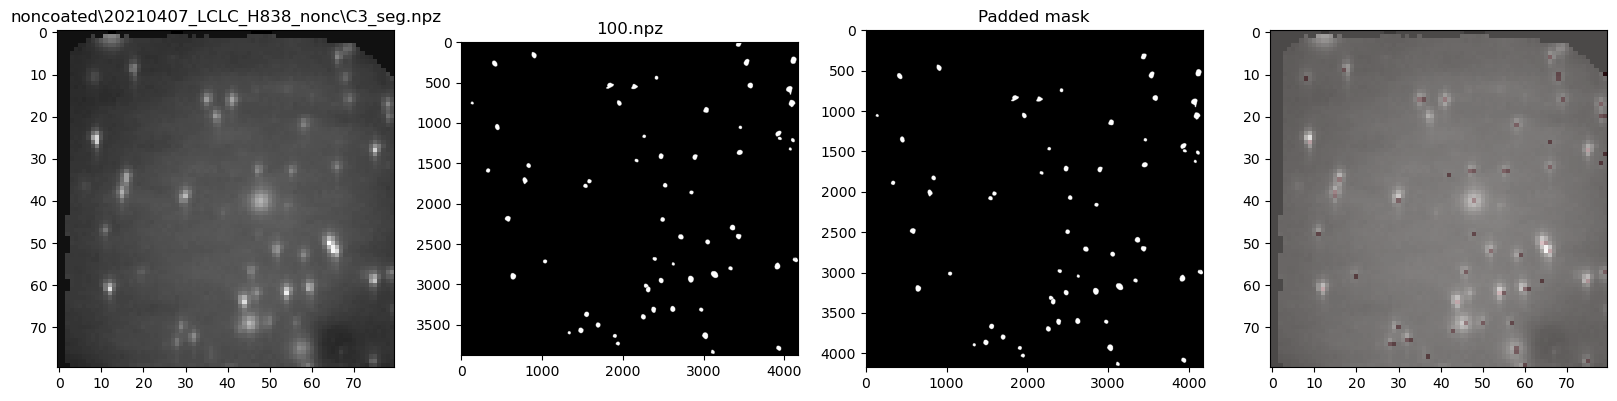

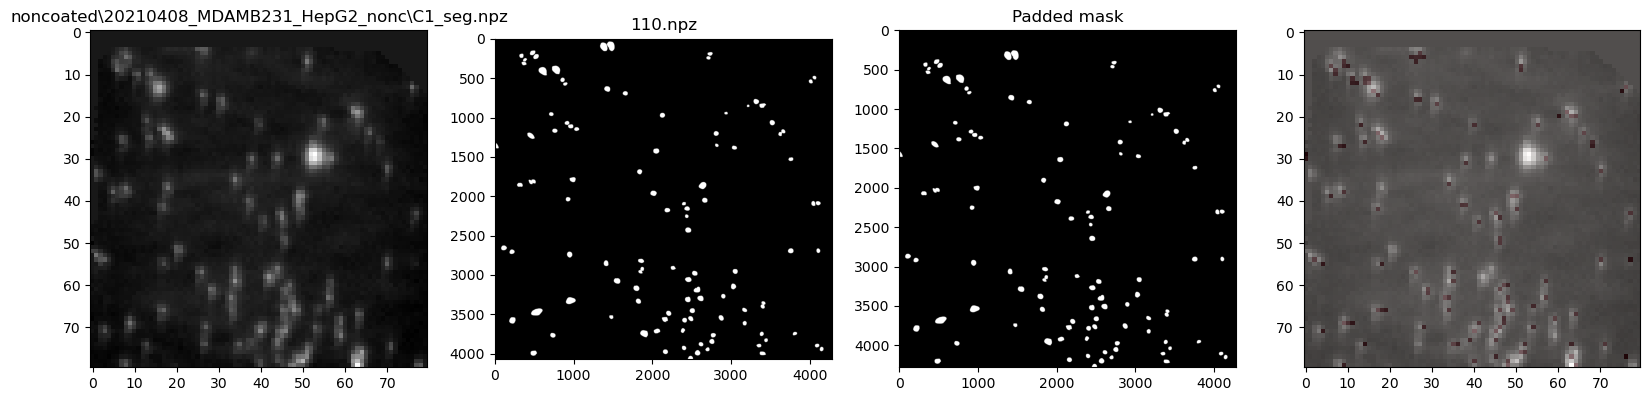

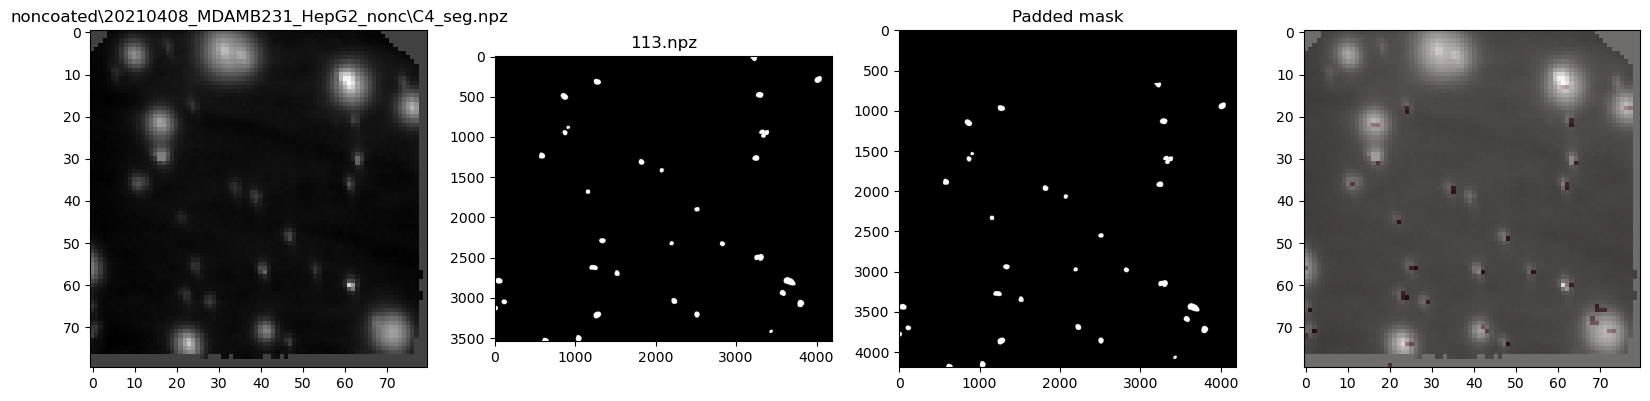

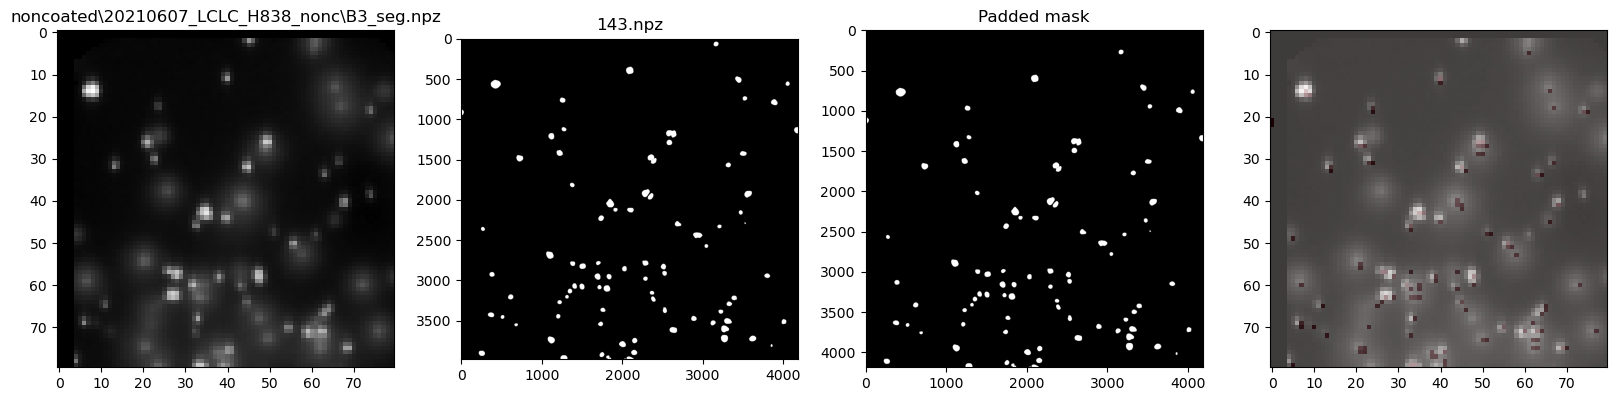

In [69]:
for file in top_padding_fix:
    # these ones need special padding to align the mask with the biosensor
    data = np.load(data_path + file)

    bio = data['biosensor'].astype(np.float32)
    name = data['old_filename']
    mask = torch.from_numpy(data['mask'].astype(bool))

    plot_alignment(bio[-1], mask, top_padding(mask), name, file)

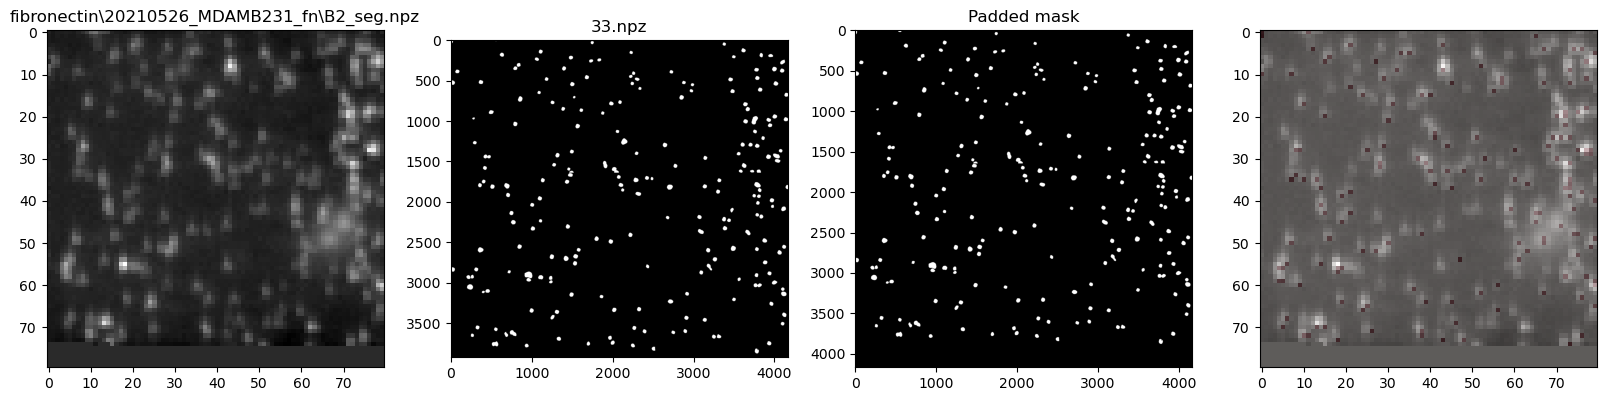

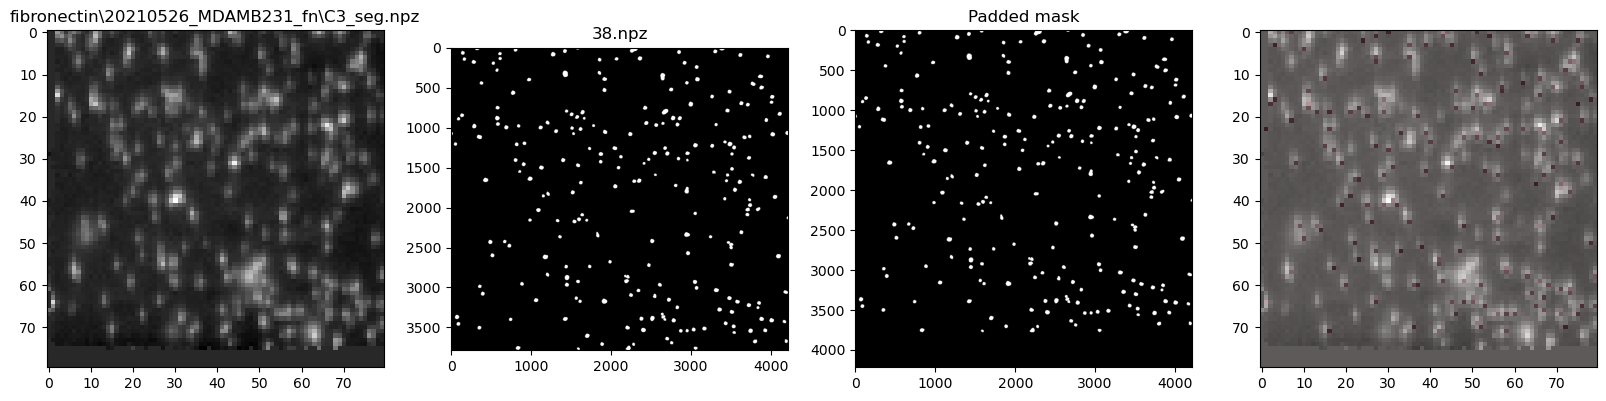

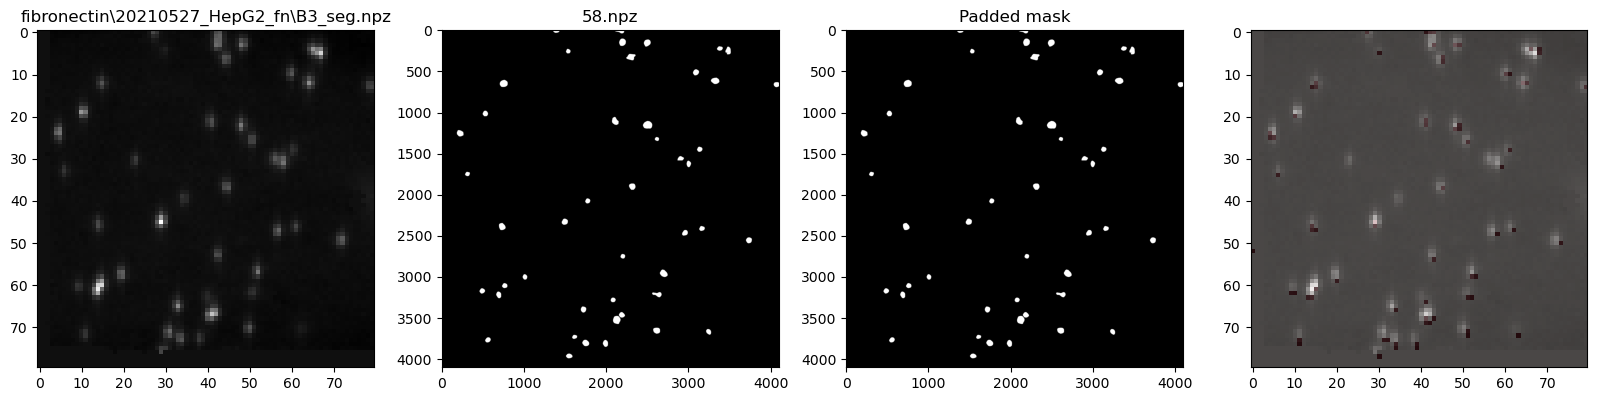

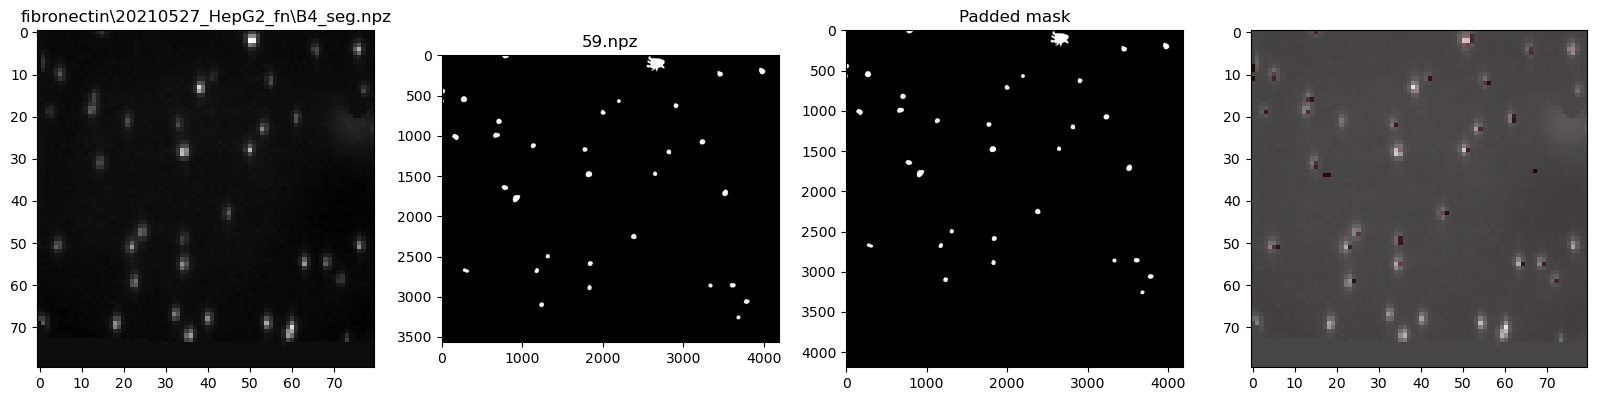

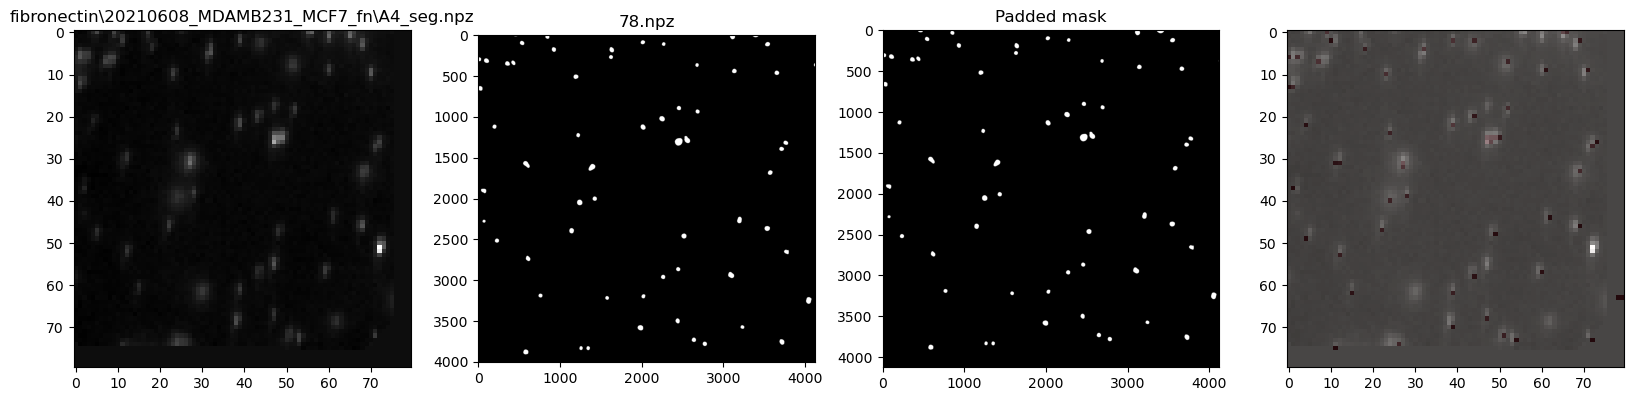

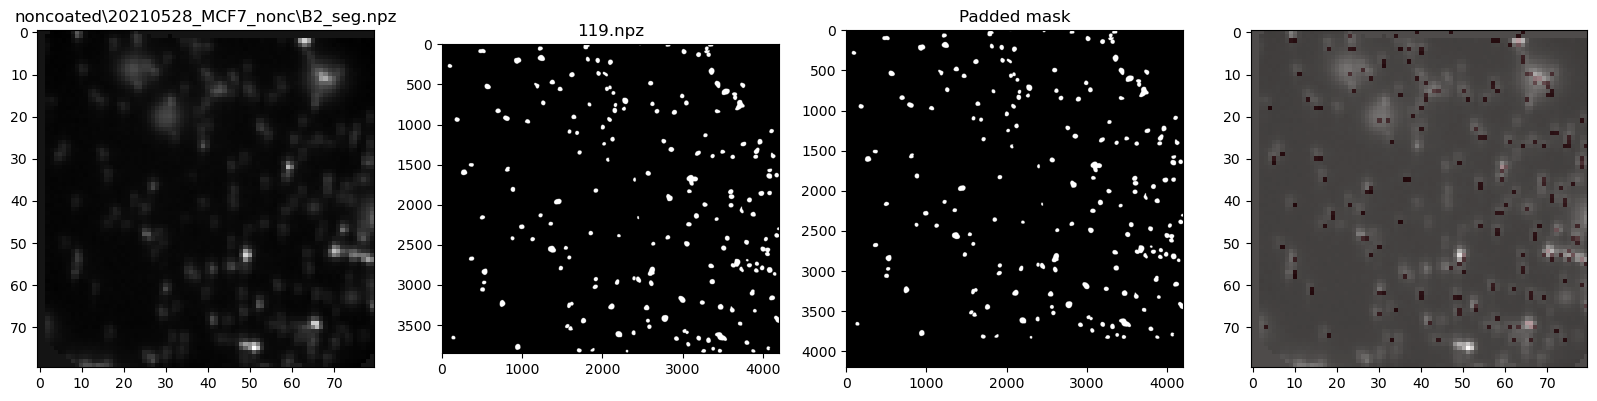

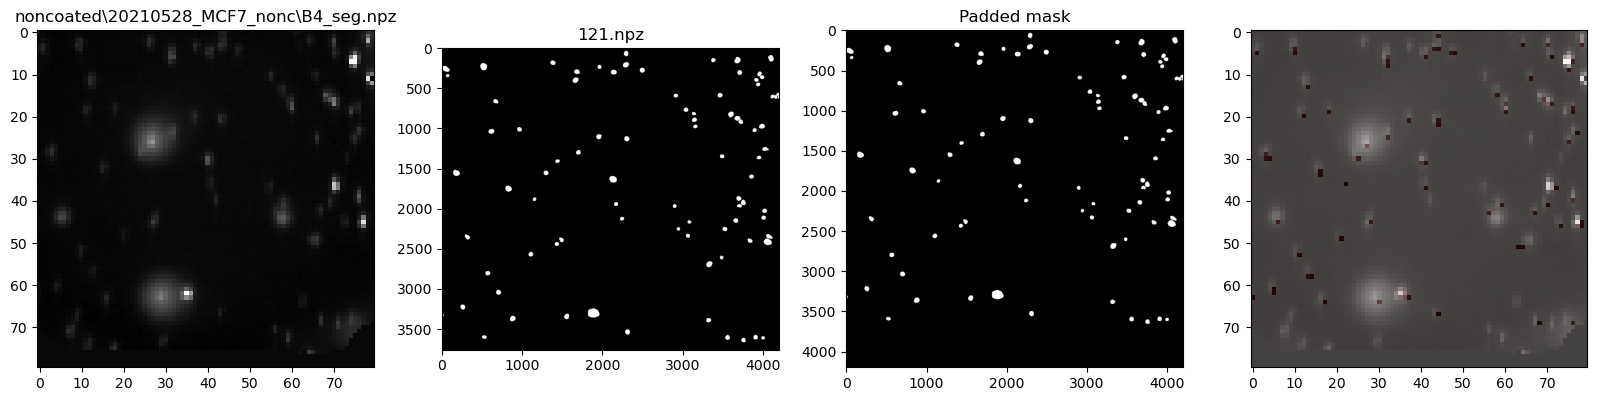

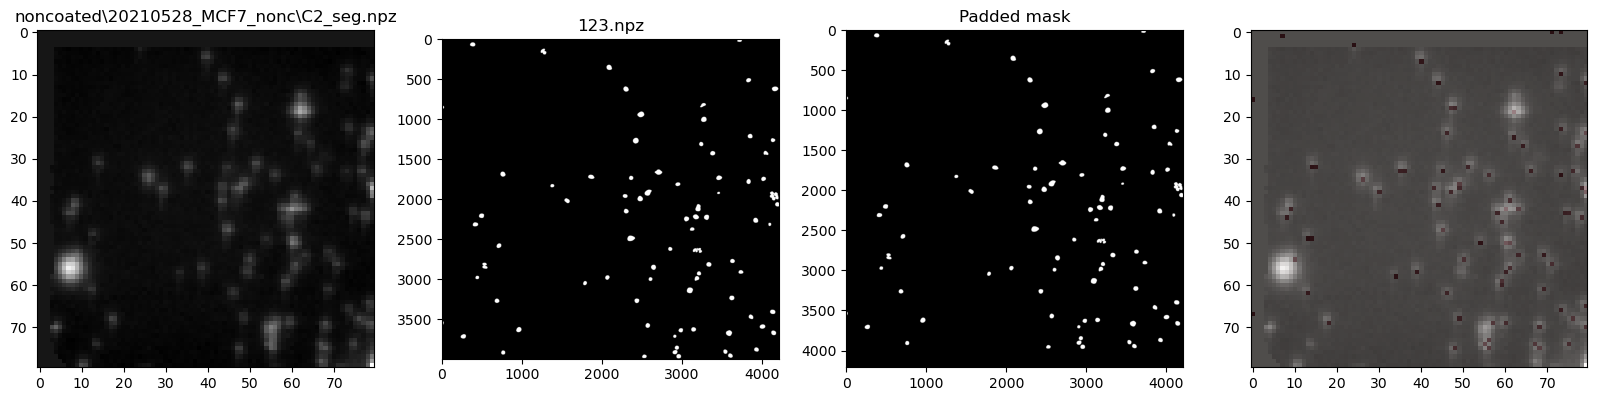

In [70]:
for file in basic_padding_fix:
    data = np.load(data_path + file)

    bio = data['biosensor'].astype(np.float32)
    name = data['old_filename']
    mask = torch.from_numpy(data['mask'].astype(bool))

    plot_alignment(bio[-1], mask, basic_mask_padding(mask), name, file)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

torch.manual_seed(42)
np.random.seed(42)

data_path = 'C:/onlab_git/Onlab/data_with_centers/'
checkpoint_dir = 'test_saves'
train_percent = 0.614
test_percent = 0.30
batch_size = 4
bio_len = 8
mask_size = 80*4

train_dataset, val_dataset, test_dataset = create_datasets(data_path, train_percent, bool, test_percent=test_percent, 
                                biosensor_length=bio_len, mask_size=mask_size, augment=False, 
                                dilation=0, input_scaling=True, upscale_mode='nearest') # nearest bilinear bicubic

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model = UNet(n_channels=bio_len, n_classes=1) #UNet4 UNet8
# model = model.to(device)

Using device cuda
